# Analysis and Parameter Estimation of LSV data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, find_peaks, find_peaks_cwt
import pandas as pd
import math
import glob

from voltammetry import preprocessing, plotting, fitting

In [2]:
##Import Experimental Reversible Data:
    
rev_exp_data = pd.read_csv("data/10mVs_Reversible.csv")
current_exp=rev_exp_data['current(A)'].values
voltage_exp=rev_exp_data['voltage(mV)'].values
time_exp=rev_exp_data['time(s)'].values


## all appropriate packages and the singular experimental data file is imported now


What is the Voltage sweep rate in mV/s?(10) 10
What is the electrode surface area in cm^2?(.2) .2
What is the initial concentration in mol/cm^3?(.00001) .00001
What is the temperature in K?(298) 298
What is the equilibrium potential in V?(.10) .1


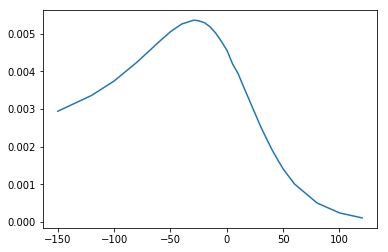

In [4]:
# Import the dimensionless voltammagram (V I) for reversible reactions

rev_dim_values = pd.read_csv("data/dimensionless_values_rev.csv")
rev_dim_current=rev_dim_values['dimensionless_current'].values
rev_dim_voltage=rev_dim_values['dimensionless_Voltage'].values

##We will now prompt the user to submit known parameters (THESE CAN BE CHANGED OR MADE MORE CONVENIENT)
sweep_rate= float(input("What is the Voltage sweep rate in mV/s?(10)"))
electrode_surface_area= float(input("What is the electrode surface area in cm^2?(.2)"))
concentration_initial= float(input("What is the initial concentration in mol/cm^3?(.00001)"))
Temp= float(input("What is the temperature in K?(298)"))
eq_pot= float(input("What is the equilibrium potential in V?(.10)"))

##we are inserting a diffusion coefficient to check math here, we will estimate this later:
Diff_coeff=0.00001

## Here we define constant variables, these can be made to user inputs if needed.
n=1
Faradays_const=96285
R_const=8.314
sigma=(n*Faradays_const*sweep_rate)/(R_const*Temp)
Pre=electrode_surface_area*concentration_initial*n*Faradays_const*math.sqrt(Diff_coeff*sigma)



output_voltage=(eq_pot+rev_dim_voltage/n)
output_current=Pre*rev_dim_current

plt.plot(output_voltage,output_current)


In [5]:
# Fitting Diff_Coeff

def test_func(rev_dim_current, D):
    return electrode_surface_area*concentration_initial*n*Faradays_const*math.sqrt(D*sigma)*rev_dim_current

params, params_covariance = curve_fit(test_func, rev_dim_current, output_current,p0=None,bounds = (0,[1]))

print(params)

[1.00000115e-05]


In [7]:
##Import Experimental Irreversible Data:
    
irrev_exp_data = pd.read_csv("data/10mVs_Irreversible.csv")
current_exp=irrev_exp_data['current(A)'].values
voltage_exp=irrev_exp_data['voltage(mV)'].values
time_exp=irrev_exp_data['time(s)'].values

print(irrev_exp_data)


## all appropriate packages and the singular experimental data file is imported now

    time(s)  voltage(mV)  current(A)
0     0.000   317.560897    0.000004
1     4.000   277.560897    0.000011
2     8.000   237.560897    0.000021
3    10.000   217.560897    0.000032
4    12.000   197.560897    0.000047
5    14.000   177.560897    0.000067
6    16.000   157.560897    0.000098
7    18.000   137.560897    0.000140
8    20.000   117.560897    0.000195
9    22.000    97.560897    0.000267
10   24.000    77.560897    0.000354
11   25.000    67.560897    0.000403
12   26.000    57.560897    0.000452
13   27.000    47.560897    0.000499
14   28.000    37.560897    0.000545
15   29.000    27.560897    0.000587
16   30.000    17.560897    0.000620
17   31.000     7.560897    0.000644
18   32.000    -2.439103    0.000660
19   33.000   -12.439103    0.000666
20   33.068   -13.119103    0.000665
21   34.000   -22.439103    0.000662
22   35.000   -32.439103    0.000651
23   36.000   -42.439103    0.000634
24   37.000   -52.439103    0.000613
25   38.000   -62.439103    0.000592
2

In [8]:
# Import the dimensionless voltammagram (V I) for irreversible reactions

irrev_dim_values = pd.read_csv("data/dimensionless_values_irrev.csv")
irrev_dim_current=irrev_dim_values['dimensionless_current'].values
irrev_dim_voltage=irrev_dim_values['dimensionless_Voltage'].values

print(irrev_dim_values)

    dimensionless_current  dimensionless_Voltage
0                  0.0030                 160.00
1                  0.0080                 140.00
2                  0.0160                 120.00
3                  0.0240                 110.00
4                  0.0350                 100.00
5                  0.0500                  90.00
6                  0.0730                  80.00
7                  0.1040                  70.00
8                  0.1450                  60.00
9                  0.1990                  50.00
10                 0.2640                  40.00
11                 0.3000                  35.00
12                 0.3370                  30.00
13                 0.3720                  25.00
14                 0.4060                  20.00
15                 0.4370                  15.00
16                 0.4620                  10.00
17                 0.4800                   5.00
18                 0.4920                   0.00
19                 0

What is the Voltage sweep rate in mV/s?(10) 10
What is the electrode surface area in cm^2?(.2) .2
What is the initial concentration in mol/cm^3?(.00001) .00001
What is the temperature in K?(298) 298
What is the equilibrium potential in mV?(100) 100


0.2331758673410904
0.0014702813052563167
0.0010385833722802097
100.0
0.000729259527407133
-2.6784742517931477


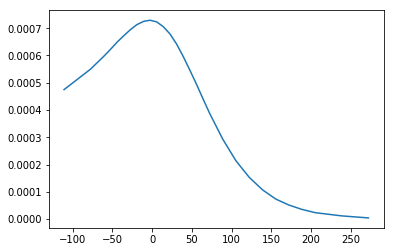

In [9]:


##We will now prompt the user to submit known parameters (THESE CAN BE CHANGED OR MADE MORE CONVENIENT)
sweep_rate= float(input("What is the Voltage sweep rate in mV/s?(10)"))
electrode_surface_area= float(input("What is the electrode surface area in cm^2?(.2)"))
concentration_initial= float(input("What is the initial concentration in mol/cm^3?(.00001)"))
Temp= float(input("What is the temperature in K?(298)"))
eq_pot= float(input("What is the equilibrium potential in mV?(100)"))

##we are inserting a diffusion coefficient to check math here, we will estimate this later:
Diff_coeff=0.00001

## Here we define constant variables, these can be made to user inputs if needed.
n=1
Faradays_const=96285
R_const=8.314
exchange_current_density=0.0002
kinetic_coefficient=exchange_current_density/n/Faradays_const/electrode_surface_area/concentration_initial
transfer_coefficient=.6
eV_const=59.1


beta=transfer_coefficient*n*Faradays_const*sweep_rate/R_const/Temp/1000
Pre=(concentration_initial*n*Faradays_const*
    math.sqrt(Diff_coeff*sweep_rate*transfer_coefficient
    *Faradays_const/(R_const*Temp*1000)))



output_voltage=eq_pot+irrev_dim_voltage/transfer_coefficient-eV_const/transfer_coefficient*math.log(math.sqrt(math.pi*Diff_coeff*beta)/kinetic_coefficient)
output_current=Pre*irrev_dim_current

plt.plot(output_voltage,output_current)

print(beta)
print(Pre)
print(kinetic_coefficient)
print(eq_pot)

print(output_current[19])
print(output_voltage[19])

In [15]:
# Fitting Diff_Coeff
from scipy import optimize


def test_func(irrev_dim_voltage, exchange_current_density):
    return eq_pot+irrev_dim_voltage/transfer_coefficient-eV_const/transfer_coefficient*math.log(math.sqrt(math.pi*Diff_coeff*beta)/(exchange_current_density/n/Faradays_const/electrode_surface_area/concentration_initial))

params, params_covariance = optimize.curve_fit(test_func, rev_dim_current, output_current,p0=None,bounds = (0,[1]))

print("Exchange current density: {}".format(params[0]))

Exchange current density: 0.00018791268257011435
